In [6]:
%matplotlib inline
! ls

# 使用mnist的資料做訓練，然後在另一個領域的數字進行辨識(不同顏色)

sample_data  sample_submission.csv  test.csv


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

batch_size =200

In [8]:
# 下載 mnist 資料
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=25)

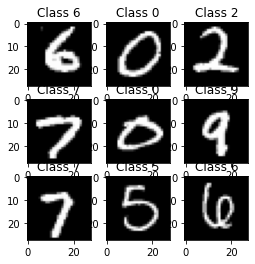

In [10]:
plt.figure(figsize=(4,4))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title("Class %s" %y_train[i])

In [11]:
#增加顏色的channel，為1
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_val = np.expand_dims(x_val, axis=3)

# 將 features(照片影像特徵值)標準化，可以提高模型預測的準確度，並且更快收斂
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255
x_val_normalized = x_val / 255

print(x_train.shape)
print(x_test.shape)

(48000, 28, 28, 1)
(10000, 28, 28, 1)


In [12]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train],label=train)
    plt.plot(train_history.history[validation],label=validation)
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.show()

In [13]:
from keras.utils import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import utils as np_utils

In [14]:
model = Sequential()

model.add(Conv2D(32, (5,5), activation="relu", padding="same", data_format="channels_last", input_shape=(28,28,1)))
model.add(Conv2D(32, (5,5), activation="relu", padding="same", data_format="channels_last", input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation="relu", padding="same", data_format="channels_last"))
model.add(Conv2D(64, (3,3), activation="relu", padding="same", data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [16]:
# optimizer: Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
y_train_onehot = np_utils.to_categorical(y_train)
y_val_onehot = np_utils.to_categorical(y_val)

gen = ImageDataGenerator(featurewise_center=False,
                         samplewise_center=False,
                         rotation_range=10, 
                         width_shift_range=0.1, 
                         shear_range=0.4,
                         height_shift_range=0.1, 
                         zoom_range=0.2,
                         brightness_range=[0.2,1.0],
                         data_format="channels_last")

gen.fit(x_train_normalized)
train_generator = gen.flow(x_train_normalized, y_train_onehot, batch_size)

test_gen = ImageDataGenerator(data_format="channels_last")
test_gen.fit(x_test_normalized)
test_generator = test_gen.flow(x_test_normalized, y_test, batch_size)

In [18]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_function = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [19]:
# 開始訓練

steps_per_epoch=int((len(x_train))/batch_size)
train_history = model.fit_generator(train_generator, 
                                    steps_per_epoch, 
                                    epochs=30, 
                                    verbose=1,
                                    validation_data=(x_val, y_val_onehot),
                                    callbacks=[learning_rate_function])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
240/240 [==============================] - 21s 86ms/step - loss: 1.1564 - accuracy: 0.6570 - val_loss: 0.1321 - val_accuracy: 0.9658
Epoch 2/30
240/240 [==============================] - 21s 86ms/step - loss: 0.2805 - accuracy: 0.9239 - val_loss: 0.0868 - val_accuracy: 0.9805
Epoch 3/30
240/240 [==============================] - 21s 86ms/step - loss: 0.1881 - accuracy: 0.9513 - val_loss: 0.0637 - val_accuracy: 0.9878
Epoch 4/30
240/240 [==============================] - 21s 86ms/step - loss: 0.1512 - accuracy: 0.9603 - val_loss: 0.0558 - val_accuracy: 0.9880
Epoch 5/30
240/240 [==============================] - 21s 87ms/step - loss: 0.1241 - accuracy: 0.9671 - val_loss: 0.0429 - val_accuracy: 0.9902
Epoch 6/30
240/240 [==============================] - 21s 87ms/step - loss: 0.1133 - accuracy: 0.9688 - val_loss: 0.0402 - val_accuracy: 0.9898
Epoch 7/30
240/240 [==============================] - 21s 88

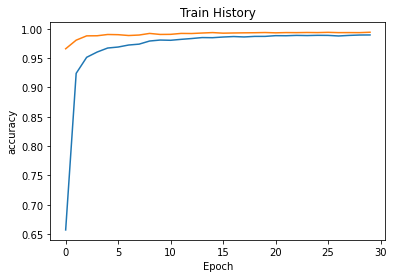

In [20]:
train_history.history

show_train_history(train_history, 'accuracy', 'val_accuracy')

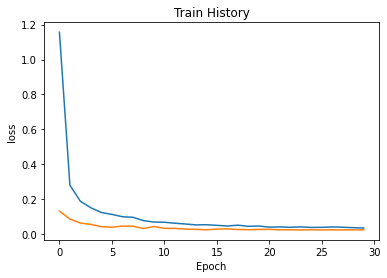

In [21]:
show_train_history(train_history, 'loss', 'val_loss')

In [22]:
y_test_onehot = np_utils.to_categorical(y_test)
score = model.evaluate(x_test, y_test_onehot)
print()
print("Accuracy {}%".format(score[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0127 - accuracy: 0.9959

Accuracy 0.9958999752998352%


In [23]:
import pandas as pd
test= pd.read_csv("test.csv")
print(test.shape)
test.head()

X_test = test.values.astype('float32')

X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 784)


(28000, 28, 28, 1)

In [24]:
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DR.csv", index=False, header=True)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
